In [164]:
model_name = './gpt2' #"gpt2"

In [165]:
import torch

device = torch.device("cuda")

## Prepare dataset and dataloader

In [166]:
!wget https://github.com/microsoft/LoRA/raw/main/examples/NLG/data/e2e/train.txt

--2024-04-16 00:38:23--  https://github.com/microsoft/LoRA/raw/main/examples/NLG/data/e2e/train.txt
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/microsoft/LoRA/main/examples/NLG/data/e2e/train.txt [following]
--2024-04-16 00:38:24--  https://raw.githubusercontent.com/microsoft/LoRA/main/examples/NLG/data/e2e/train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9624463 (9.2M) [text/plain]
Saving to: ‘train.txt.39’

train.txt.39        100%[===================>]   9.18M  3.27MB/s    in 2.8s    

2024-04-16 00:38:27 (3.27 MB/s) - ‘train.txt.39’ saved [9624463/9624463]



In [167]:
!wget https://github.com/microsoft/LoRA/raw/main/examples/NLG/data/e2e/test.txt

--2024-04-16 00:38:28--  https://github.com/microsoft/LoRA/raw/main/examples/NLG/data/e2e/test.txt
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/microsoft/LoRA/main/examples/NLG/data/e2e/test.txt [following]
--2024-04-16 00:38:28--  https://raw.githubusercontent.com/microsoft/LoRA/main/examples/NLG/data/e2e/test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1351149 (1.3M) [text/plain]
Saving to: ‘test.txt.39’

test.txt.39         100%[===================>]   1.29M  2.70MB/s    in 0.5s    

2024-04-16 00:38:29 (2.70 MB/s) - ‘test.txt.39’ saved [1351149/1351149]



Show the downloaded data (first 5 rows).

In [168]:
!head -n 5 train.txt

name : The Vaults | Type : pub | price : more than £ 30 | customer rating : 5 out of 5 | near : Café Adriatic||The Vaults pub near Café Adriatic has a 5 star rating . Prices start at £ 30 . 
name : The Cambridge Blue | Type : pub | food : English | price : cheap | near : Café Brazil||Close to Café Brazil , The Cambridge Blue pub serves delicious Tuscan Beef for the cheap price of £ 10.50 . Delicious Pub food . 
name : The Eagle | Type : coffee shop | food : Japanese | price : less than £ 20 | customer rating : low | area : riverside | family friendly : yes | near : Burger King||The Eagle is a low rated coffee shop near Burger King and the riverside that is family friendly and is less than £ 20 for Japanese food . 
name : The Mill | Type : coffee shop | food : French | price : £ 20 - 25 | area : riverside | near : The Sorrento||Located near The Sorrento is a French Theme eatery and coffee shop called The Mill , with a price range at £ 20- £ 25 it is in the riverside area . 
name : Loch 

Convert above data into JsonL format.

In [169]:
import sys
import io
import json

def format_convert(read_file, write_file):
    with open(read_file, "r", encoding="utf8") as reader, \
    	 open(write_file, "w", encoding="utf8") as writer :
    	for line in reader:
    		items = line.strip().split("||")
    		context = items[0]
    		completion = items[1].strip("\n")
    		x = {}
    		x["context"] = context
    		x["completion"] = completion
    		writer.write(json.dumps(x)+"\n")

format_convert("train.txt", "train_formatted.jsonl")
format_convert("test.txt", "test_formatted.jsonl")

Show the converted data (first 5 rows).

In [170]:
with open("train_formatted.jsonl", "r") as reader:
    for _ in range(5):
        print(next(reader))

{"context": "name : The Vaults | Type : pub | price : more than \u00a3 30 | customer rating : 5 out of 5 | near : Caf\u00e9 Adriatic", "completion": "The Vaults pub near Caf\u00e9 Adriatic has a 5 star rating . Prices start at \u00a3 30 ."}

{"context": "name : The Cambridge Blue | Type : pub | food : English | price : cheap | near : Caf\u00e9 Brazil", "completion": "Close to Caf\u00e9 Brazil , The Cambridge Blue pub serves delicious Tuscan Beef for the cheap price of \u00a3 10.50 . Delicious Pub food ."}

{"context": "name : The Eagle | Type : coffee shop | food : Japanese | price : less than \u00a3 20 | customer rating : low | area : riverside | family friendly : yes | near : Burger King", "completion": "The Eagle is a low rated coffee shop near Burger King and the riverside that is family friendly and is less than \u00a3 20 for Japanese food ."}

{"context": "name : The Mill | Type : coffee shop | food : French | price : \u00a3 20 - 25 | area : riverside | near : The Sorrento", "com

Load tokenizer from Hugging Face.

In [171]:


from transformers import AutoTokenizer
import os

tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    fast_tokenizer=True)
os.environ["TOKENIZERS_PARALLELISM"] = "false"

Set block size which is used to separate long text for model consumption.<br>


In [172]:
block_size = 512

print(f"Max length of tokens is {tokenizer.model_max_length} in this model.")
print(f"But here we use max {block_size} tokens in the training.")

Max length of tokens is 1024 in this model.
But here we use max 512 tokens in the training.


Process data


In [173]:
from torch.utils.data import DataLoader
import pandas as pd

def fill_ignore_label(l, c):
    l[:len(c) - 1] = [-100] * (len(c) - 1)
    return l

def pad_tokens(tokens, max_seq_length, padding_token):
    res_tokens = tokens[:max_seq_length]
    token_len = len(res_tokens)
    res_tokens = res_tokens + \
        [padding_token for _ in range(max_seq_length - token_len)]
    return res_tokens

def collate_batch(batch):
    # tokenize both context and completion respectively
    # (context and completion is delimited by "\n")
    context_list = list(zip(*batch))[0]
    context_list = [c + "\n" for c in context_list]
    completion_list = list(zip(*batch))[1]
    context_result = tokenizer(context_list)
    context_tokens = context_result["input_ids"]
    context_masks = context_result["attention_mask"]
    completion_result = tokenizer(completion_list)
    completion_tokens = completion_result["input_ids"]
    completion_masks = completion_result["attention_mask"]
    # concatenate token
    inputs = [i + j for i, j in zip(context_tokens, completion_tokens)]
    masks = [i + j for i, j in zip(context_masks, completion_masks)]
    # create label
    eos_id = tokenizer.encode(tokenizer.eos_token)[0]
    labels = [t[1:] + [eos_id] for t in inputs]
    labels = list(map(fill_ignore_label, labels, context_tokens))
    # truncate and pad tokens
    inputs = [pad_tokens(t, block_size, 0) for t in inputs] # OPT and GPT-2 doesn't use pad token (instead attn mask is used)
    masks = [pad_tokens(t, block_size, 0) for t in masks]
    labels = [pad_tokens(t, block_size, -100) for t in labels]
    # convert to tensor
    inputs = torch.tensor(inputs, dtype=torch.int64).to(device)
    masks = torch.tensor(masks, dtype=torch.int64).to(device)
    labels = torch.tensor(labels, dtype=torch.int64).to(device)
    return inputs, labels, masks

Dataloader

In [174]:
batch_size = 8
gradient_accumulation_steps = 16

data = pd.read_json("train_formatted.jsonl", lines=True)
dataloader = DataLoader(
    list(zip(data["context"], data["completion"])),
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_batch
)

## Load model

Load model from Hugging Face.

In [175]:
from transformers import AutoModelForCausalLM, AutoConfig

config = AutoConfig.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    config=config,
).to(device)

Generate text


In [176]:
def generate_text(model, input, mask, eos_id, pred_sequence_length):
    predicted_last_id = -1
    start_token_len = torch.sum(mask).cpu().numpy()
    token_len = start_token_len
    with torch.no_grad():
        while (predicted_last_id != eos_id) and \
              (token_len - start_token_len < pred_sequence_length):
            output = model(
                input_ids=input,
                attention_mask=mask,
            )
            predicted_ids = torch.argmax(output.logits, axis=-1).cpu().numpy()
            predicted_last_id = predicted_ids[0][token_len - 1]
            input[0][token_len] = predicted_last_id
            mask[0][token_len] = 1
            token_len = torch.sum(mask).cpu().numpy()
    return input, token_len

In [177]:
eos_id = tokenizer.encode(tokenizer.eos_token)[0]

result = tokenizer("Once upon a time,")
input = result["input_ids"]
mask = result["attention_mask"]
input = pad_tokens(input, block_size, 0)
mask = pad_tokens(mask, block_size, 0)
input = torch.tensor([input], dtype=torch.int64).to(device)
mask = torch.tensor([mask], dtype=torch.int64).to(device)

result_token, result_len = generate_text(
    model,
    input,
    mask,
    eos_id,
    pred_sequence_length=15)
print(tokenizer.decode(result_token[0][:result_len]))

result = tokenizer("My name is Clara and I am")
input = result["input_ids"]
mask = result["attention_mask"]
input = pad_tokens(input, block_size, 0)
mask = pad_tokens(mask, block_size, 0)
input = torch.tensor([input], dtype=torch.int64).to(device)
mask = torch.tensor([mask], dtype=torch.int64).to(device)

result_token, result_len = generate_text(
    model,
    input,
    mask,
    eos_id,
    pred_sequence_length=15)
print(tokenizer.decode(result_token[0][:result_len]))

Once upon a time, the world was a place of great beauty and great danger. The world was
My name is Clara and I am a woman. I am a woman who is a woman. I am a


In [178]:
test_data = pd.read_json("test_formatted.jsonl", lines=True)
test_data = test_data[::2]  # because it's duplicated
test_loader = DataLoader(
    list(zip(test_data["context"], [""] * len(test_data["context"]))),
    batch_size=1,
    shuffle=True,
    collate_fn=collate_batch
)

for i, (input, _, mask) in enumerate(test_loader):
    if i == 5:
        break
    print("********** input **********")
    input_len = torch.sum(mask).cpu().numpy()
    print(tokenizer.decode(input[0][:input_len]))
    result_token, result_len = generate_text(
        model,
        input,
        mask,
        eos_id,
        pred_sequence_length=30)
    print("********** result **********")
    print(tokenizer.decode(result_token[0][:result_len]))

********** input **********
name : The Wrestlers | Type : pub | food : Japanese | price : moderate | area : riverside | family friendly : yes | near : Raja Indian Cuisine

********** result **********
name : The Wrestlers | Type : pub | food : Japanese | price : moderate | area : riverside | family friendly : yes | near : Raja Indian Cuisine

Raja Indian Cuisine : Raja Indian Cuisine : Raja Indian Cuisine : Raja Indian Cuisine : Raja Indian Cu
********** input **********
name : The Vaults | Type : pub | food : French | price : more than £ 30 | area : riverside | family friendly : no | near : Raja Indian Cuisine

********** result **********
name : The Vaults | Type : pub | food : French | price : more than £ 30 | area : riverside | family friendly : no | near : Raja Indian Cuisine

The Vaults | Type : pub | food : French | price : more than £ 30 | area : riverside | family friendly : no | near
********** input **********
name : The Vaults | Type : restaurant | food : Indian | price : h

In [179]:
model
# for transformer


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

First we build custom linear layer with LoRA as follows.

In [180]:
import math
from torch import nn

class LoRA_Linear(nn.Module):
    def __init__(self, weight, bias, lora_dim):
        super(LoRA_Linear, self).__init__()

        row, column = weight.shape

        # restore Linear
        if bias is None:
            self.linear = nn.Linear(column, row, bias=False)
            self.linear.load_state_dict({"weight": weight})
        else:
            self.linear = nn.Linear(column, row)
            self.linear.load_state_dict({"weight": weight, "bias": bias})

        # create LoRA weights (with initialization)
        self.lora_right = nn.Parameter(torch.zeros(column, lora_dim))
        nn.init.kaiming_normal_(self.lora_right) #, a=math.sqrt(5)
        self.lora_left = nn.Parameter(torch.zeros(lora_dim, row))

    def forward(self, input):
        x = self.linear(input)
        y = input @ self.lora_right @ self.lora_left
        return x + y

Replace targeting linear layers with LoRA layers.


In [181]:
# lora_dim = 128
lora_dim = 8
# get target module name
target_names = []
for name, module in model.named_modules():
    if "transformer.h.10" in name or "transformer.h.11" in name:
        if "attn.c_attn" in name:
            target_names.append(name)

# replace each module with LoRA
for name in target_names:
    name_struct = name.split(".")
    # get target module
    module_list = [model]
    for struct in name_struct:
        module_list.append(getattr(module_list[-1], struct))
    # build LoRA
    lora = LoRA_Linear(
        weight = torch.transpose(module_list[-1].weight, 0, 1),
        bias = module_list[-1].bias,
        lora_dim = lora_dim,
    ).to(device)
    
    # replace
    module_list[-2].__setattr__(name_struct[-1], lora)

See how model is changed.

In [182]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-9): 10 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (10-11): 2 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): LoRA_Linear(
            (linear): Linear(in_features=768, out_features=2304, bias=True)
          )
        

Finally, freeze all parameters except for LoRA parameters.

In [183]:
for name, param in model.named_parameters():
    if "lora_right" in name or "lora_left" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

## Fine-tune

### Optimizer


In [185]:
# optimizer = torch.optim.AdamW(
#     params=model.parameters(),
#     lr=0.0002,
#     betas=(0.9, 0.999),
#     eps=1e-6,
# )

# from came_pytorch import CAME
# optimizer = CAME(
#     model.parameters(),
#     lr=2e-4,
#     weight_decay=1e-2,
#     betas=(0.9, 0.999, 0.9999),
#     eps=(1e-30, 1e-16)
# )

from transformers.optimization import Adafactor, AdafactorSchedule
optimizer = Adafactor(model.parameters(), scale_parameter=True, relative_step=True, warmup_init=True, lr=None)
    

# from adafactor1 import Adafactor
# optimizer = Adafactor(model.parameters()) # try lr = 1e-3

### Schedular

In [186]:
from torch.optim.lr_scheduler import LambdaLR, LRScheduler, ExponentialLR, CosineAnnealingLR

num_epochs = 2
num_warmup_steps = 500

num_update_steps = math.ceil(len(dataloader) / batch_size / gradient_accumulation_steps)
def _get_linear_schedule(current_step):
    if current_step < num_warmup_steps:
        return float(current_step) / float(max(1, num_warmup_steps))
    return max(0.0, float(num_update_steps * num_epochs - current_step) / float(max(1, num_update_steps * num_epochs - num_warmup_steps)))

# scheduler = LambdaLR(optimizer, lr_lambda=_get_linear_schedule)

# scheduler = CosineAnnealingLR(optimizer, T_max= 32)
scheduler = AdafactorSchedule(optimizer)

In [187]:
import pickle
import numpy as np
def save_matrix(matrix, file_name):
    
    with open(file_name, 'wb') as file:
        pickle.dump(matrix, file)


Run fine-tuning.

In [188]:
from torch.nn import functional as F

# if os.path.exists("loss.txt"):
#     os.remove("loss.txt")

second_layer_mean = []
last_layer_mean = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
    model.train()
    for i, (inputs, labels, masks) in enumerate(dataloader):
        with torch.set_grad_enabled(True):
            outputs = model(
                input_ids=inputs,
                attention_mask=masks,
            )
            loss = F.cross_entropy(outputs.logits.transpose(1,2), labels)
            loss.backward()
            if ((i + 1) % gradient_accumulation_steps == 0) or \
               (i + 1 == len(dataloader)):
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()

            print(f"Epoch {epoch+1} {math.ceil((i + 1) / batch_size / gradient_accumulation_steps)}/{num_update_steps} - loss: {loss.item() :2.4f}", end="\r")
            
            for name, parameters in model.named_parameters():
                if "transformer.h.10" in name: #or "transformer.h.11" in name:
                    if 'c_attn.lora_right' in name:
                        mx1 = parameters
                    if 'c_attn.lora_left' in name:
                        mx2 = parameters
                        result_lastsecond_layer = mx1 @ mx2
                        # result_lastsecond_layer = result_lastsecond_layer.cpu().detach().numpy()
                        # with open("./save/attention/matrix_secondlayer_1.txt", 'a') as f:
                        #     np.savetxt(f, result_lastsecond_layer)
                        # print('attention param of second layer =', result_lastsecond_layer)
                        # save_matrix(result_lastsecond_layer, file_name = './save/attention/second_layer_matrix_1.pkl')
                        second_layer_mean.append(torch.mean(result_lastsecond_layer).item())
                if "transformer.h.11" in name:
                    if 'c_attn.lora_right' in name:
                        mx1 = parameters
                    if 'c_attn.lora_left' in name:
                        mx2 = parameters
                        result_last_layer = mx1 @ mx2
                        # result_last_layer = result_last_layer.cpu().detach().numpy()
                        # with open("./save/attention/matrix_lastlayer_1.txt", 'a') as f:
                        #     np.savetxt(f, result_last_layer)
                        last_layer_mean.append(torch.mean(result_last_layer).item())
        # record loss
        with open("./save/attention/loss_3.txt", "a") as f:
            f.write(str(loss.item()))
            f.write("\n")
    print("")

# save model
torch.save(model.state_dict(), "finetuned_gpt2_3.bin")

Epoch 1 42/42 - loss: 3.8000
Epoch 2 42/42 - loss: 3.8049


Plot

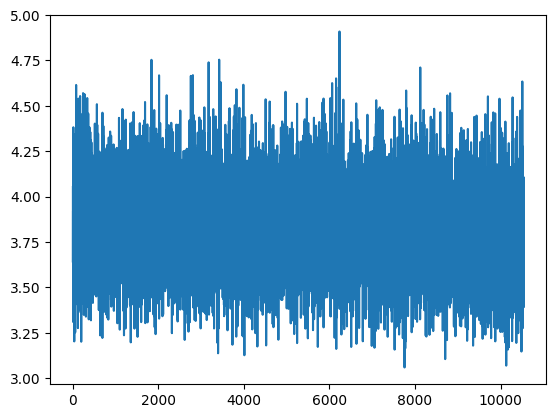

In [189]:
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv("./save/attention/loss_3.txt")
plt.plot(data)
plt.show()

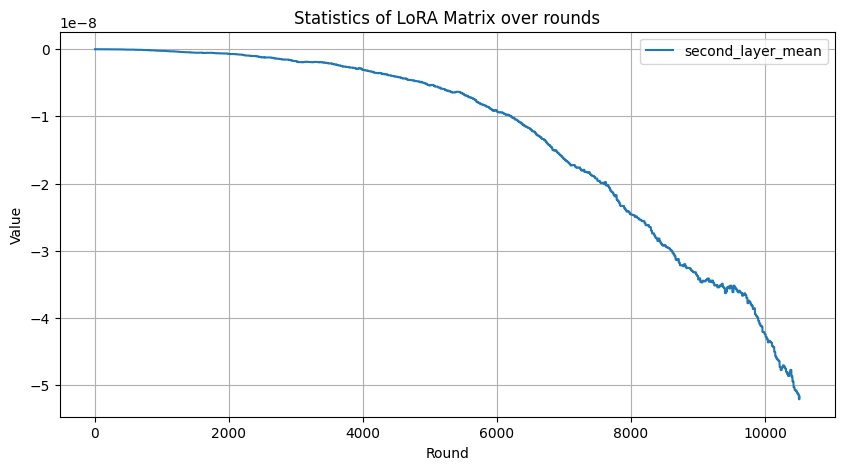

In [190]:
rounds = range(1, len(last_layer_mean)+1)
plt.figure(figsize = (10,5))
plt.plot(rounds, second_layer_mean, label = 'second_layer_mean')
plt.xlabel('Round')
plt.ylabel('Value')
plt.title('Statistics of LoRA Matrix over rounds')
plt.legend()
plt.grid(True)
plt.show()

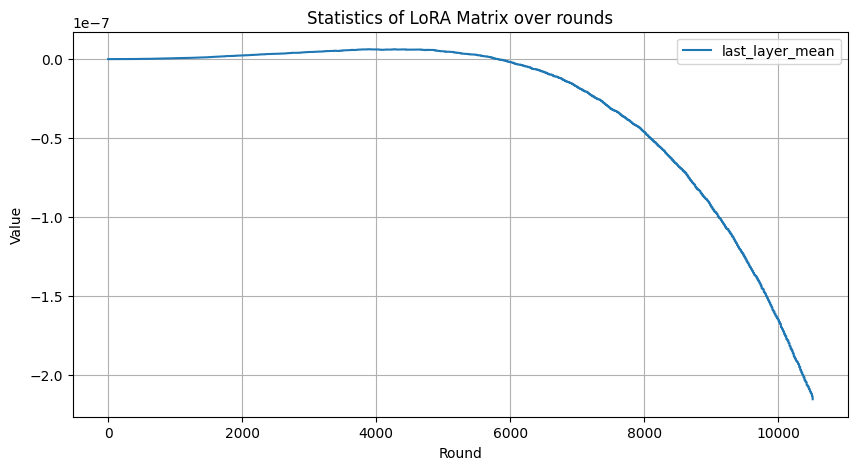

In [191]:
rounds = range(1, len(last_layer_mean)+1)
plt.figure(figsize = (10,5))
plt.plot(rounds, last_layer_mean, label = 'last_layer_mean')
plt.xlabel('Round')
plt.ylabel('Value')
plt.title('Statistics of LoRA Matrix over rounds')
plt.legend()
plt.grid(True)
plt.show()

## Generate text with fine-tuned model


In [192]:
test_data = pd.read_json("test_formatted.jsonl", lines=True)
test_data = test_data[::2]  # because it's duplicated
test_loader = DataLoader(
    list(zip(test_data["context"], [""] * len(test_data["context"]))),
    batch_size=1,
    shuffle=True,
    collate_fn=collate_batch
)

for i, (input, _, mask) in enumerate(test_loader):
    if i == 5:
        break
    print("********** input **********")
    input_len = torch.sum(mask).cpu().numpy()
    print(tokenizer.decode(input[0][:input_len]))
    result_token, result_len = generate_text(
        model,
        input,
        mask,
        eos_id,
        pred_sequence_length=30)
    print("********** result **********")
    print(tokenizer.decode(result_token[0][:result_len]))

********** input **********
name : The Phoenix | Type : restaurant | food : Fast food | price : more than £ 30 | area : riverside | family friendly : yes | near : Raja Indian Cuisine

********** result **********
name : The Phoenix | Type : restaurant | food : Fast food | price : more than £ 30 | area : riverside | family friendly : yes | near : Raja Indian Cuisine

: | restaurant : : : : : : : : : : : : : : : : : : : : : : : : : :
********** input **********
name : Green Man | Type : pub | food : Italian | area : riverside | family friendly : yes | near : Express by Holiday Inn

********** result **********
name : Green Man | Type : pub | food : Italian | area : riverside | family friendly : yes | near : Express by Holiday Inn

: Express by Express by : Express Express by : Express Express by : Express Express Express Express Express Express Express Express Express Express Express Express Express Express Express
********** input **********
name : The Punter | Type : restaurant | food 